<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

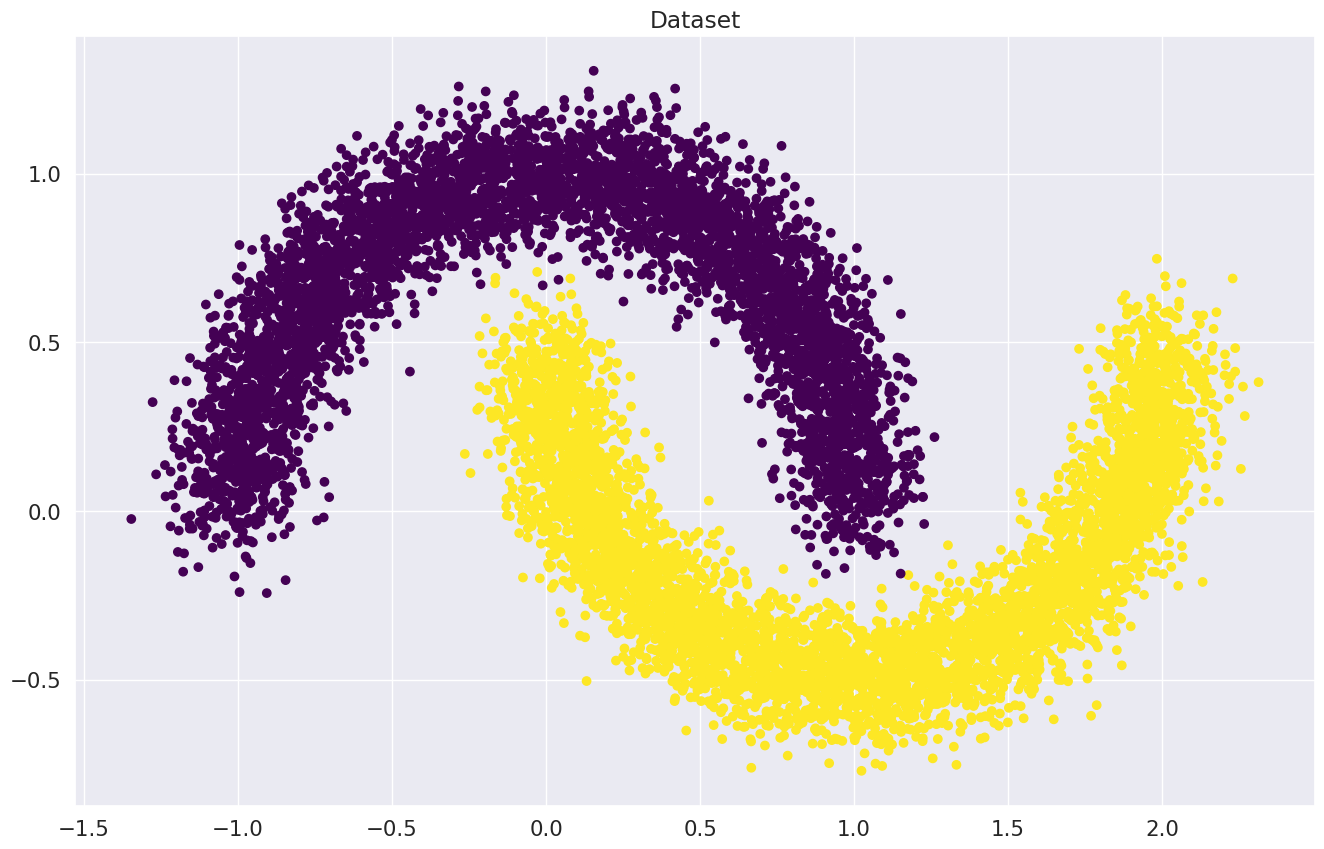

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t = (torch.from_numpy(X_train)).to(torch.float32) # YOUR CODE GOES HERE
y_train_t = (torch.from_numpy(y_train)).to(torch.float32) # YOUR CODE GOES HERE
X_val_t = (torch.from_numpy(X_val)).to(torch.float32)
y_val_t = (torch.from_numpy(y_val)).to(torch.float32) # YOUR CODE GOES HERE

In [7]:
print(X_train_t)
print(y_train_t)

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])
tensor([1., 1., 0.,  ..., 1., 1., 0.])


In [8]:
torch.Tensor.size(X_train_t)

torch.Size([7500, 2])

In [9]:
X_train_t.dtype

torch.float32

Создаем `Dataset` и `DataLoader`.

In [10]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [11]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad = True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(out_features, requires_grad = True))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [12]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [13]:
count_params = 0
for_bar = []
print(linear_regression.parameters)
for i in range(len(list(linear_regression.parameters()))):
  count_params += len(list(linear_regression.parameters())[i])
  print(list(linear_regression.parameters())[i])
print(count_params)

<bound method Module.parameters of LinearRegression()>
Parameter containing:
tensor([[-0.3869],
        [-0.4842]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)
3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [14]:
tol = 1e-3
losses = []
max_epochs = 10
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)# YOUR CODE. Use linear_regression to get outputs
        print(f'outp ={outp}')
        print(f'outp_view ={outp.view(-1)}')
        loss =  loss_function(outp.view(-1), y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)# YOUR CODE. Compute probabilities
        print(f' {probabilities} - probabilities')
        preds = (probabilities > 0.5).type(torch.long)
        print(f'{preds} - pred')
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Выходные данные были обрезаны до нескольких последних строк (5000).
        [-0.3529],
        [-1.4301],
        [-1.4476],
        [ 0.2483],
        [-0.2966],
        [-2.4315],
        [ 0.9868],
        [ 2.1915],
        [-2.6642],
        [ 2.9877],
        [-1.5315],
        [ 1.2785],
        [ 2.5599],
        [-0.9066],
        [-2.3338],
        [ 2.8342],
        [-0.2587],
        [ 1.9505],
        [-3.1007],
        [ 2.8005],
        [-0.8672],
        [ 1.0831],
        [ 1.5194],
        [ 2.7077],
        [-2.3549],
        [-3.2871],
        [-0.7887],
        [-0.3115],
        [-2.0156],
        [ 0.7948],
        [-2.4383],
        [-2.8289],
        [ 2.4236],
        [ 1.6105],
        [-0.0458],
        [ 1.9106],
        [-2.7884],
        [ 2.5030],
        [ 3.5056],
        [-1.0522],
        [ 0.2749],
        [-1.8122],
        [ 1.1121],
        [-2.7658],
        [-2.3733],
        [-1.2989],
        [-3.1574],
        [ 0.6387],
        [-2.2784],
 

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

### Визуализируем результаты

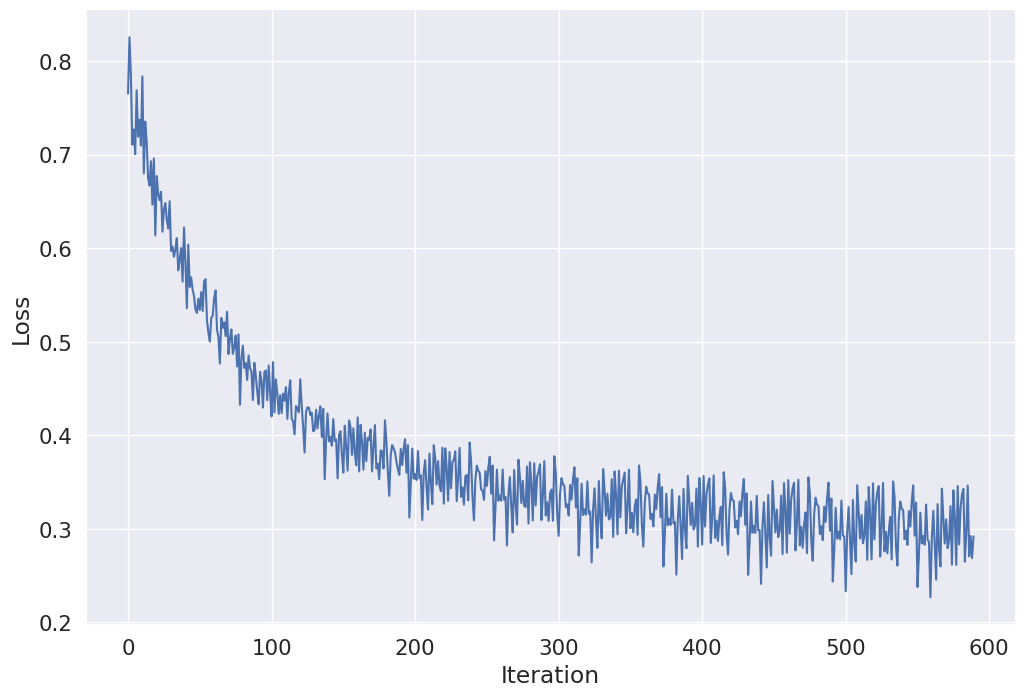

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

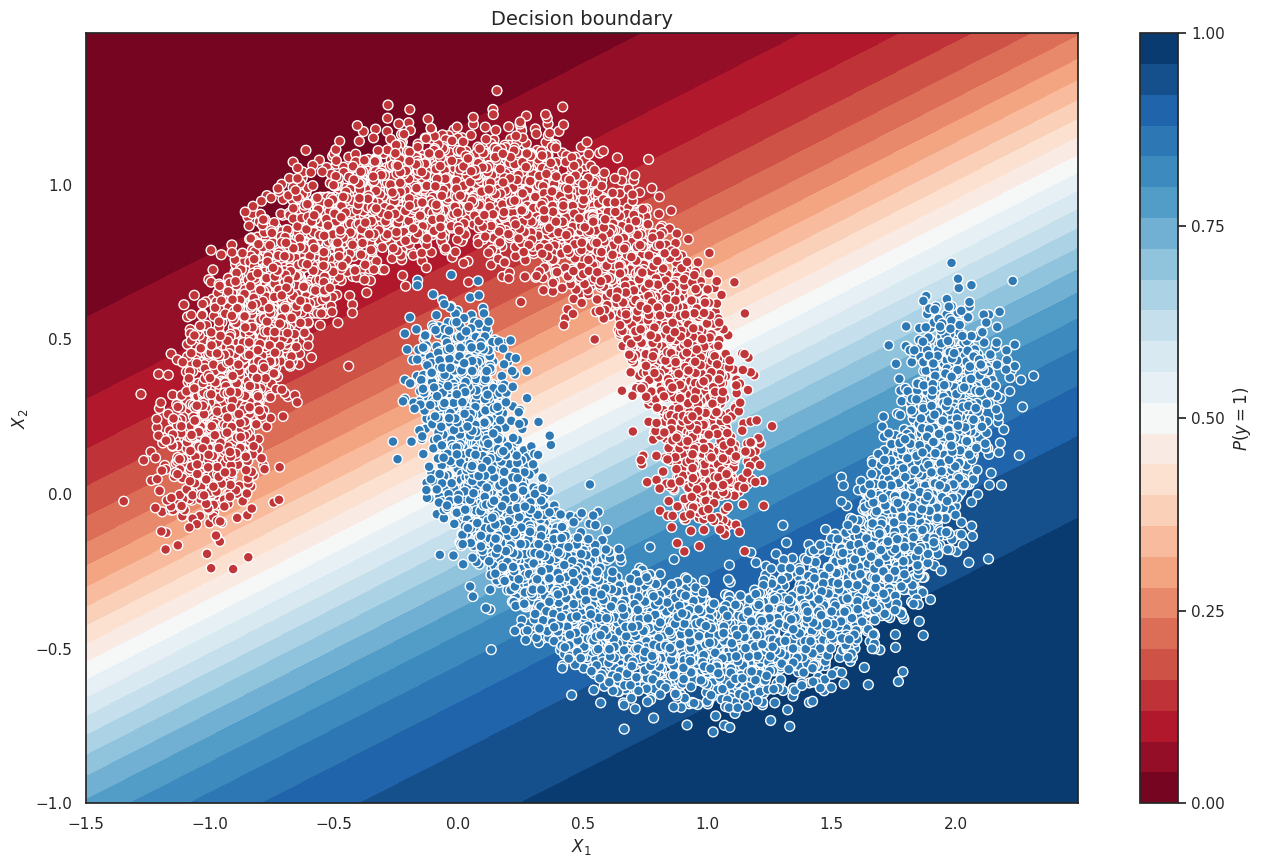

In [16]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [17]:
print(X)

[[ 0.45549318 -0.12550304]
 [-0.70421731  0.04130827]
 [ 0.41379864  0.79132194]
 ...
 [-0.03803096  0.24540791]
 [ 0.8698024   0.52329471]
 [ 1.16429638 -0.3798397 ]]


### Задание. Реализуйте predict и посчитайте accuracy на test.

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch)
        probability = torch.sigmoid(preds)
        bin_pred = (probability > 0.5).type(torch.long)
        predictions = np.hstack((predictions, bin_pred.numpy().flatten()))
    return predictions.flatten()

In [19]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size = 128)
val_dataloader = DataLoader(val_dataset, batch_size = 128)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val_t, predict(val_dataloader, linear_regression))
# YOUR CODE. Compute total accuracy

0.8732

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0,8664

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [25]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True,
                                               num_workers = 2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle = False,
                                               num_workers = 2)
classes = tuple(str(i) for i in range(10))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [26]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [31]:
i = np.random.randint(low = 0, high = 60000)
torch.Tensor.size(train_dataloader.dataset.train_data[i])

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([28, 28])

In [33]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)

)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [42]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
print(loaders.items())
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          if k == "train":
            model.train()  # <------------------ переводим модель в режим train
            optimizer.zero_grad()  # <--------- обнуляем градиенты модели
            outp = model(x_batch)

          else:
            model.eval()# YOUR CODE. Set model to ``eval`` mode and calculate outputs
            with torch.no_grad():
              outp =torch.softmax(model(x_batch), dim = 1)


          preds = outp.argmax(-1)
          correct =  (preds == y_batch).sum()# YOUR CODE GOES HERE
          all =  len(preds)# YOUR CODE GOES HERE
          epoch_correct += correct.item()
          epoch_all += all
          if k == "train":
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


dict_items([('train', <torch.utils.data.dataloader.DataLoader object at 0x7ade94e6bfa0>), ('valid', <torch.utils.data.dataloader.DataLoader object at 0x7ade77596890>)])
Epoch: 1
Loader: train. Accuracy: 0.9073166666666667
Loader: valid. Accuracy: 0.9397
Epoch: 2
Loader: train. Accuracy: 0.9467666666666666
Loader: valid. Accuracy: 0.9593
Epoch: 3
Loader: train. Accuracy: 0.9557166666666667
Loader: valid. Accuracy: 0.9564
Epoch: 4
Loader: train. Accuracy: 0.9600666666666666
Loader: valid. Accuracy: 0.9529
Epoch: 5
Loader: train. Accuracy: 0.9636
Loader: valid. Accuracy: 0.9596
Epoch: 6
Loader: train. Accuracy: 0.9649166666666666
Loader: valid. Accuracy: 0.9589
Epoch: 7
Loader: train. Accuracy: 0.9673666666666667
Loader: valid. Accuracy: 0.9665
Epoch: 8
Loader: train. Accuracy: 0.9691
Loader: valid. Accuracy: 0.968
Epoch: 9
Loader: train. Accuracy: 0.9713666666666667
Loader: valid. Accuracy: 0.9499
Epoch: 10
Loader: train. Accuracy: 0.9728666666666667
Loader: valid. Accuracy: 0.9615


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [44]:
elu_accuracy = accuracy["valid"]

In [45]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
  )

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = torch.softmax(model(x_batch), dim=1)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [47]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8494333333333334
Loader: valid. Accuracy: 0.8948
Epoch: 2
Loader: train. Accuracy: 0.88275
Loader: valid. Accuracy: 0.888
Epoch: 3
Loader: train. Accuracy: 0.88925
Loader: valid. Accuracy: 0.8923
Epoch: 4
Loader: train. Accuracy: 0.8931666666666667
Loader: valid. Accuracy: 0.8725
Epoch: 5
Loader: train. Accuracy: 0.8949166666666667
Loader: valid. Accuracy: 0.8983
Epoch: 6
Loader: train. Accuracy: 0.8974
Loader: valid. Accuracy: 0.9027
Epoch: 7
Loader: train. Accuracy: 0.8987166666666667
Loader: valid. Accuracy: 0.9091
Epoch: 8
Loader: train. Accuracy: 0.90035
Loader: valid. Accuracy: 0.8898
Epoch: 9
Loader: train. Accuracy: 0.9011666666666667
Loader: valid. Accuracy: 0.9025
Epoch: 10
Loader: train. Accuracy: 0.90185
Loader: valid. Accuracy: 0.9051
Epoch: 1
Loader: train. Accuracy: 0.9018166666666667
Loader: valid. Accuracy: 0.9368
Epoch: 2
Loader: train. Accuracy: 0.9429
Loader: valid. Accuracy: 0.9451
Epoch: 3
Loader: train. Accuracy: 0.953016666666

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

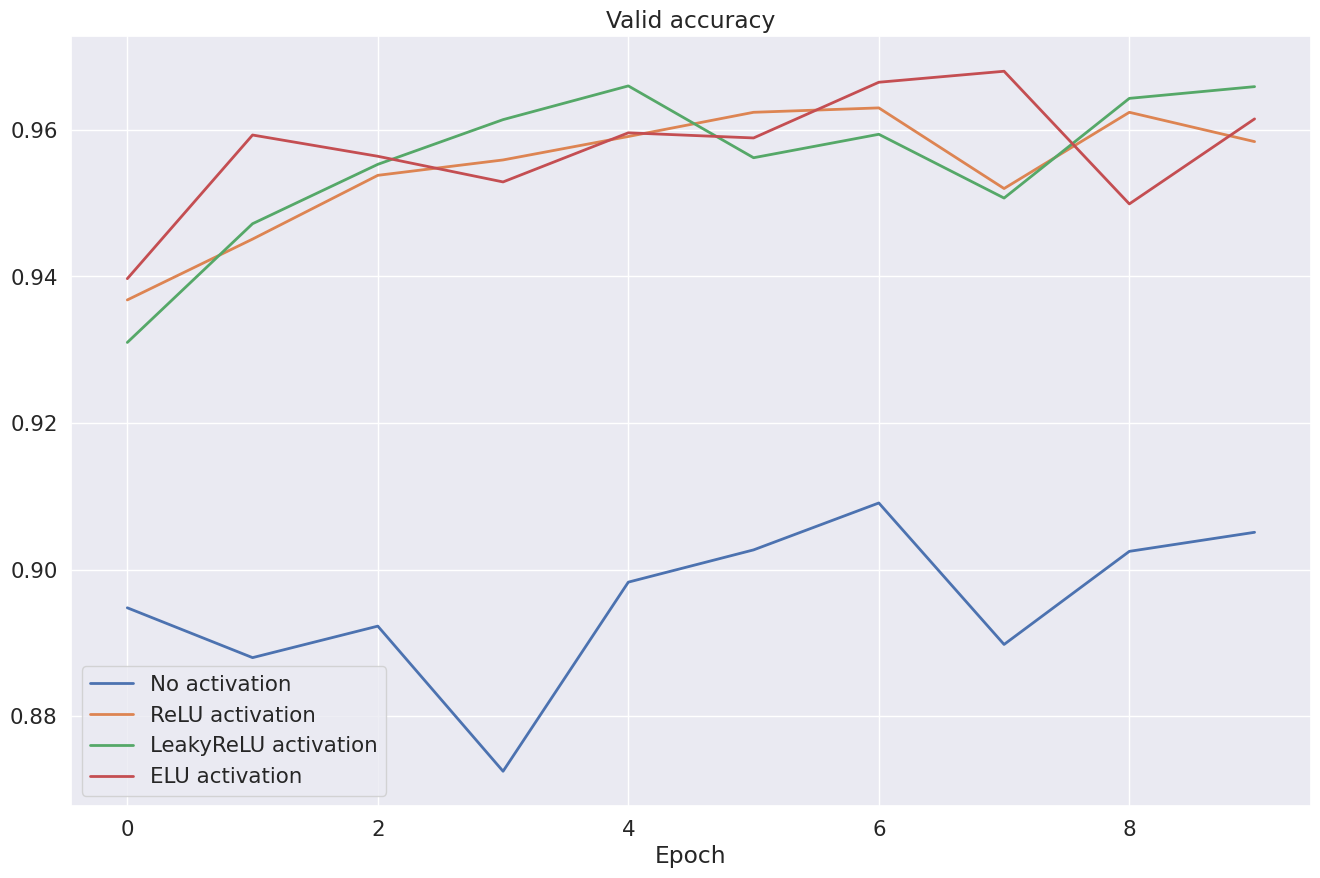

In [48]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

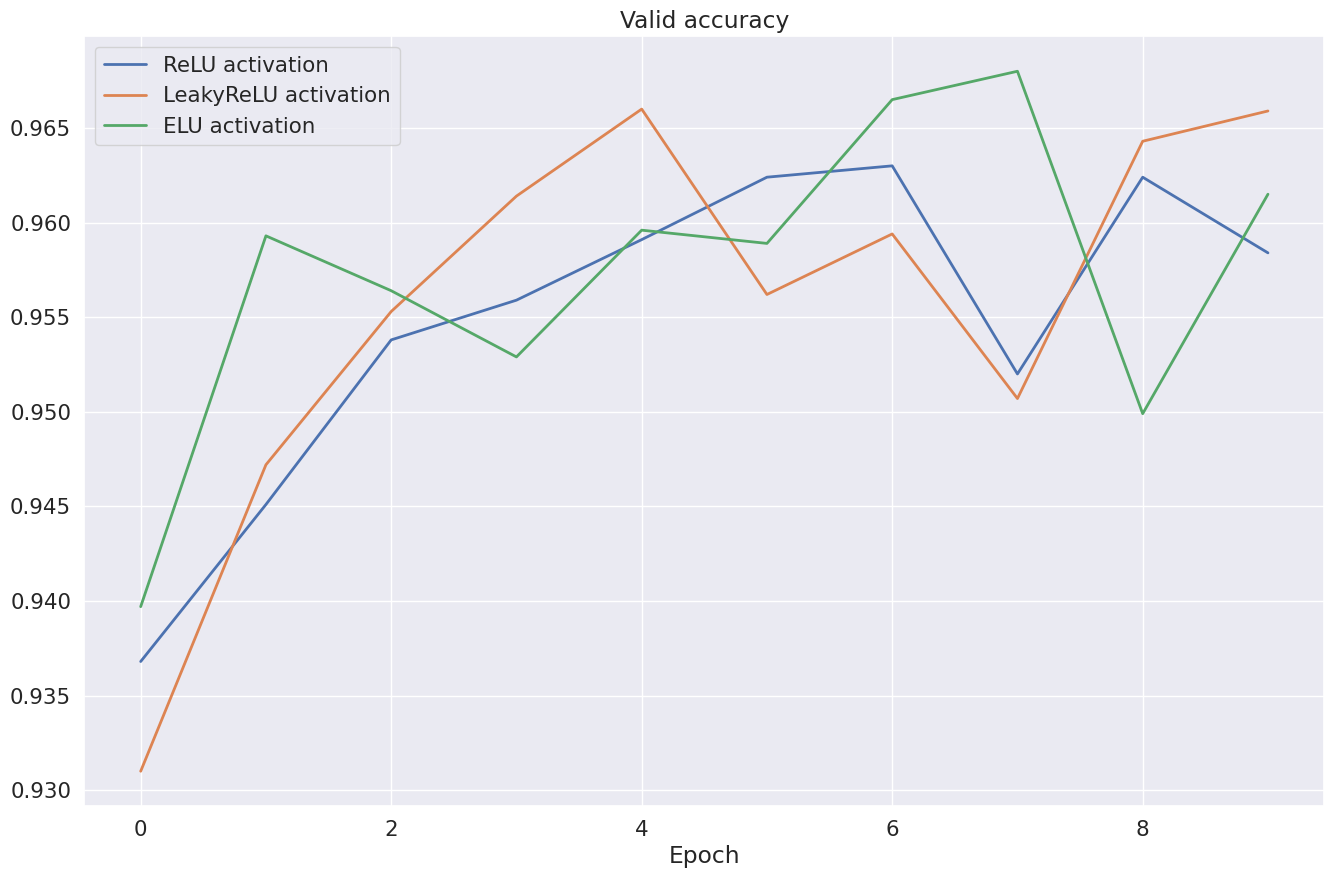

In [49]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [53]:
!wget https://wallbox.ru/wallpapers/main/201251/gorod-rozhdestvo-novyj-01af0f6.jpg -O sample_photo.jpg

--2023-12-22 01:13:04--  https://wallbox.ru/wallpapers/main/201251/gorod-rozhdestvo-novyj-01af0f6.jpg
Resolving wallbox.ru (wallbox.ru)... 172.67.138.200, 104.21.70.189, 2606:4700:3035::ac43:8ac8, ...
Connecting to wallbox.ru (wallbox.ru)|172.67.138.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3535086 (3.4M) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]   3.37M  4.76MB/s    in 0.7s    

2023-12-22 01:13:05 (4.76 MB/s) - ‘sample_photo.jpg’ saved [3535086/3535086]



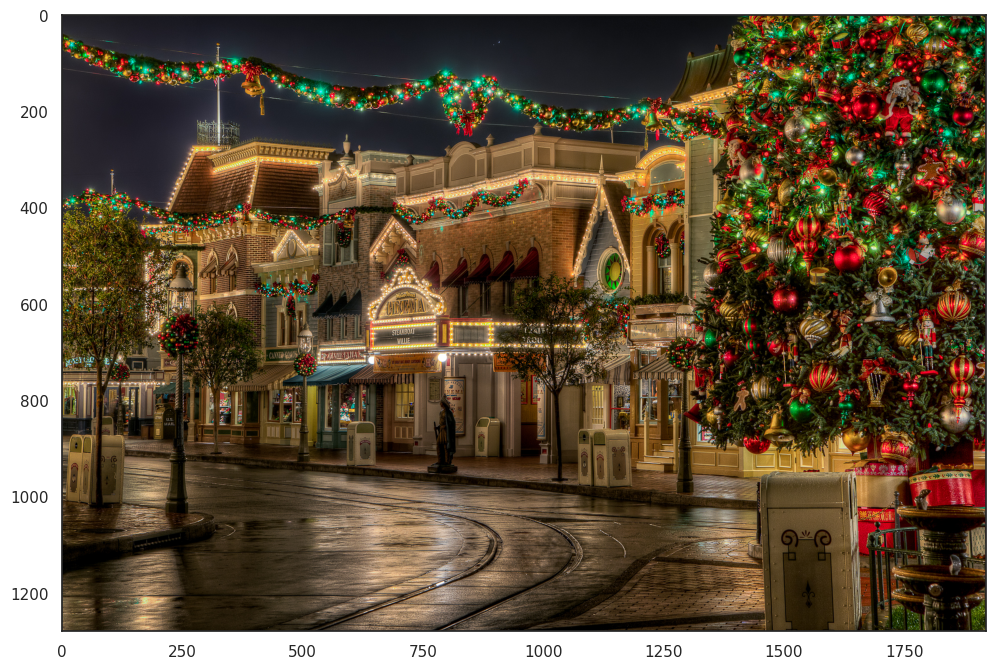

In [54]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [55]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

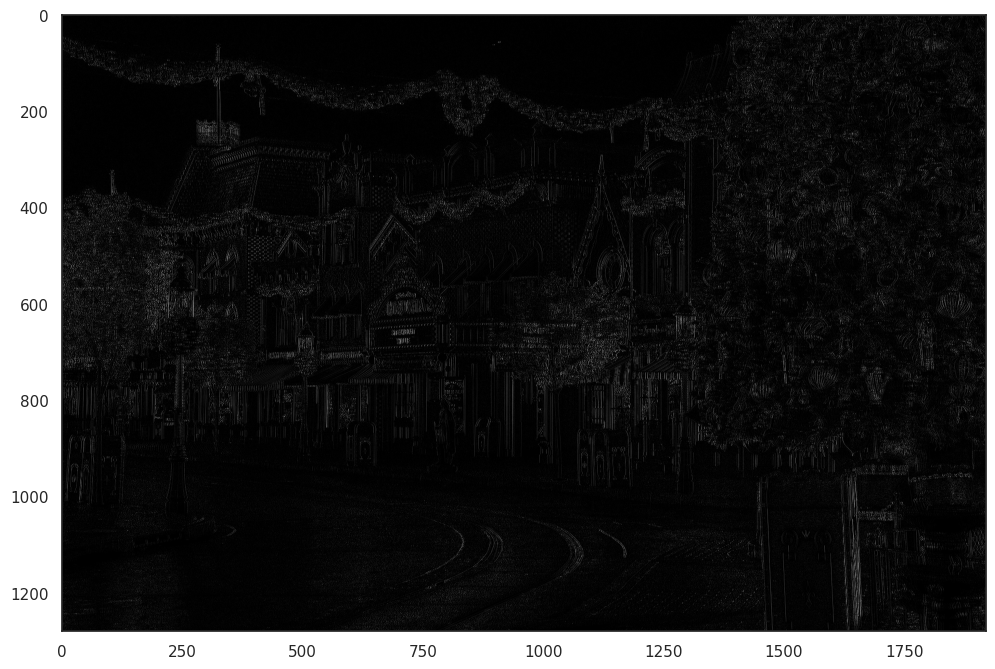

In [56]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [70]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))#YOUR CODE. Apply layers created in __init__.
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [71]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [72]:
max_epochs = 10
accuracy = {"train": [], "valid": []}


for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = torch.softmax(model(x_batch), dim=1)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9530666666666666
Loader: valid. Accuracy: 0.9835
Epoch: 2
Loader: train. Accuracy: 0.9816833333333334
Loader: valid. Accuracy: 0.9839
Epoch: 3
Loader: train. Accuracy: 0.9872333333333333
Loader: valid. Accuracy: 0.9846
Epoch: 4
Loader: train. Accuracy: 0.9899166666666667
Loader: valid. Accuracy: 0.9838
Epoch: 5
Loader: train. Accuracy: 0.9908166666666667
Loader: valid. Accuracy: 0.9869
Epoch: 6
Loader: train. Accuracy: 0.9920333333333333
Loader: valid. Accuracy: 0.989
Epoch: 7
Loader: train. Accuracy: 0.99255
Loader: valid. Accuracy: 0.9877
Epoch: 8
Loader: train. Accuracy: 0.9934333333333333
Loader: valid. Accuracy: 0.9867
Epoch: 9
Loader: train. Accuracy: 0.9930666666666667
Loader: valid. Accuracy: 0.9871
Epoch: 10
Loader: train. Accuracy: 0.9937333333333334
Loader: valid. Accuracy: 0.9863


In [73]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

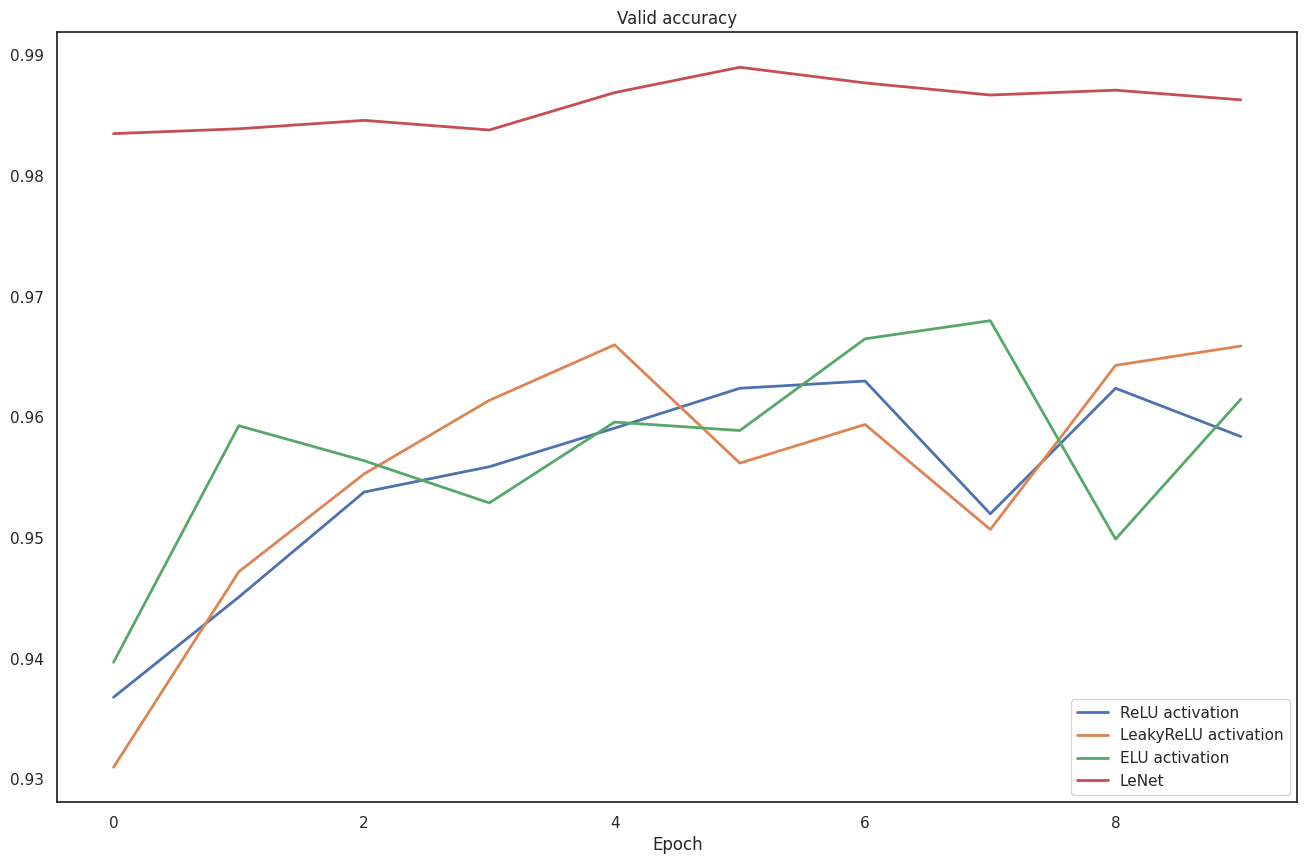

In [74]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [76]:
round(max(lenet_accuracy), 2)

0.99